In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import os
import cv2

import ipywidgets as widgets
from ipywidgets import interact

%matplotlib inline

## Creating dataframe 

In [2]:
# csv containing Q_table
Q_Table_nonfoveated = pd.read_csv('Q_tables/Q_table_nonfoveated_first10.csv', sep=',')
Q_Table_strong = pd.read_csv('Q_tables/Q_table_strongfoveated_first10.csv', sep=',')
Q_Table_weak = pd.read_csv('Q_tables/Q_table_weakfoveated_first10.csv', sep=',')

# Q_Table_nonfoveated = pd.read_csv('Q_tables/Q_table_nonfoveatedVGG_first10.csv', sep=',')
# Q_Table_strong = pd.read_csv('Q_tables/Q_table_strongfoveatedVGG_first10.csv', sep=',')
# Q_Table_weak = pd.read_csv('Q_tables/Q_table_weakfoveatedVGG_first10.csv', sep=',')

im_name = Q_Table_nonfoveated['class']
nonfoveated = Q_Table_nonfoveated['score']

#non-foveated misses 3 classes
Q_Table_strong = Q_Table_strong[Q_Table_strong['class'].isin(im_name)].reset_index(drop=True)
Q_Table_weak = Q_Table_weak[Q_Table_weak['class'].isin(im_name)].reset_index(drop=True)

strong_center = Q_Table_strong['(2, 2)']
strong_mean = Q_Table_strong.mean(axis=1)
strong_std = Q_Table_strong.std(axis=1)
weak_center = Q_Table_weak['(2, 2)']
weak_mean = Q_Table_weak.mean(axis=1)
weak_std = Q_Table_weak.std(axis=1)

# first element of each row is the name
strong_random = pd.Series([np.random.choice(i[1:]) for i in Q_Table_strong.values])
strong_min = pd.Series([np.min(i[1:]) for i in Q_Table_strong.values])
strong_max = pd.Series([np.max(i[1:]) for i in Q_Table_strong.values])
weak_random = pd.Series([np.random.choice(i[1:]) for i in Q_Table_weak.values])
weak_min = pd.Series([np.min(i[1:]) for i in Q_Table_weak.values])
weak_max = pd.Series([np.max(i[1:]) for i in Q_Table_weak.values])

df = pd.concat([im_name, nonfoveated, strong_center, strong_random, strong_min, strong_max, strong_mean, strong_std, 
                weak_center, weak_random, weak_min, weak_max, weak_mean, weak_std], axis=1)
df.columns = ['im_name', 'nonfoveated', 'strong_center', 'strong_random', 'strong_min', 'strong_max', 'strong_mean', 'strong_std', 
              'weak_center', 'weak_random', 'weak_min', 'weak_max', 'weak_mean', 'weak_std']
print(df.head(5))

           im_name  nonfoveated  strong_center  strong_random  strong_min  \
0  n01530575_10007     0.000990       0.026203       4.369442    0.001568   
1  n01530575_10017     0.000021       0.006935       0.042404    0.002781   
2  n01530575_10018     0.004688       5.004531       4.149057    0.877871   
3  n01530575_10021     0.181235       0.397975       3.494187    0.397975   
4  n01530575_10022     0.009766       0.663794       4.419268    0.041506   

   strong_max  strong_mean  strong_std  weak_center  weak_random  weak_min  \
0    4.369442     1.672372    1.420941     0.000353     0.000204  0.000036   
1    4.270340     0.767970    1.119754     0.000015     0.000046  0.000008   
2    8.070860     5.640421    1.612628     0.007004     0.001474  0.001036   
3    6.170032     4.354275    1.286615     0.133471     0.131956  0.041958   
4    5.088811     2.496060    1.384007     0.003321     0.002903  0.000362   

   weak_max  weak_mean  weak_std  
0  0.013432   0.003424  0.004020 

# Plots



## No foveation

In [3]:
result = df


def plot_fig(cutoff_left, cutoff_right, show, fov_strength):
    fig=plt.figure(dpi=200, facecolor='w', edgecolor='k')
    
    nonfoveated = result['nonfoveated'][cutoff_left:cutoff_right]
    index = result.index.tolist()[cutoff_left:cutoff_right]
    
    foveated = result['weak_min']
    mean = result['weak_mean']
    std = result ['weak_std']
    if fov_strength == "strong":
        foveated = result['strong_min']
        mean = result['strong_mean']
        std = result ['strong_std']
        
    foveated = foveated[cutoff_left:cutoff_right]
    mean = mean[cutoff_left:cutoff_right]
    std = std[cutoff_left:cutoff_right]
    
    
    if show == "foveation & no foveation":
        plt.plot(foveated, 'go', markersize=5, fillstyle='none')
        plt.plot(nonfoveated, 'ro', markersize=2)
        plt.legend(['foveation', 'no foveation'])
    elif show == "mean & no foveation":
        plt.plot(nonfoveated, 'ro', markersize=2)
        plt.errorbar(x=index, y=mean, yerr=std, linestyle='None', marker='s', ms=1, mew=4, lw=1)
        plt.legend(['no foveation', 'foveated mean with SD'])
    elif show == "foveation & mean":
        plt.plot(foveated, 'go', markersize=5, fillstyle='none')
        plt.errorbar(x=index, y=mean, yerr=std, linestyle='None', marker='s', ms=1, mew=4, lw=1)
        plt.legend(['foveation', 'foveated mean with SD'])
    else: # all
        plt.plot(foveated, 'go', markersize=5, fillstyle='none')
        plt.plot(nonfoveated, 'ro', markersize=2)
        plt.errorbar(x=index, y=mean, yerr=std, linestyle='None', marker='s', ms=1, mew=4, lw=1)
        plt.legend(['foveation', 'no foveation', 'foveated mean with SD'])

    plt.ylabel('cross-entropy loss')
    plt.xlabel('images')
    
    plt.show()
    fig.savefig("images/foveation_vs_no-foveation", bbox_inches='tight')

def update(sortby, cutoff_left, cutoff_right, sort_ascending, show, fov_strength):
    global result
    
    if not sortby == 'nonfoveated':
        sortby = fov_strength + '_' + sortby
  
    result = df.sort_values(sortby, ascending=sort_ascending).reset_index(drop=True)
    plot_fig(cutoff_left, cutoff_right, show, fov_strength)
    
interact(update, 
         sortby=['nonfoveated', 'min', 'mean', 'std'],
         fov_strength=['weak', 'strong'],
         show=['foveation & no foveation', 'mean & no foveation', 'foveation & mean', 'all'],
         cutoff_left=widgets.IntSlider(value=0, min=0.0, max=len(result)),
         cutoff_right=widgets.IntSlider(value=len(result), min=0.0, max=len(result)),
        sort_ascending=False)


interactive(children=(Dropdown(description='sortby', options=('nonfoveated', 'min', 'mean', 'std'), value='non…

<function __main__.update(sortby, cutoff_left, cutoff_right, sort_ascending, show, fov_strength)>

In [4]:
def update(cutoff, verbose=True):
    nonfoveated = result['nonfoveated'][:cutoff]
    mean = result['weak_mean'][:cutoff]
    minimum = result['weak_min'][:cutoff]
    
    percentage_mean = 100 * sum(mean < nonfoveated)/ len(nonfoveated)
    percentage_min = 100 * sum(minimum < nonfoveated)/ len(nonfoveated)

    if verbose:
        print("percentage of foveated images that are on average better then nonfoveated:", percentage_mean, '%')
        print("percentage of foveated images that are on at best better then nonfoveated:", percentage_min, '%')
    else:
        return percentage_mean, percentage_min
    
interact(update, cutoff = widgets.IntSlider(value=len(result), min=1, max=len(result)))

interactive(children=(IntSlider(value=13000, description='cutoff', max=13000, min=1), Checkbox(value=True, des…

<function __main__.update(cutoff, verbose=True)>

In [5]:
percentages_mean , percentages_min = zip(*[update(i, verbose=False) for i in range(1, len(result))])

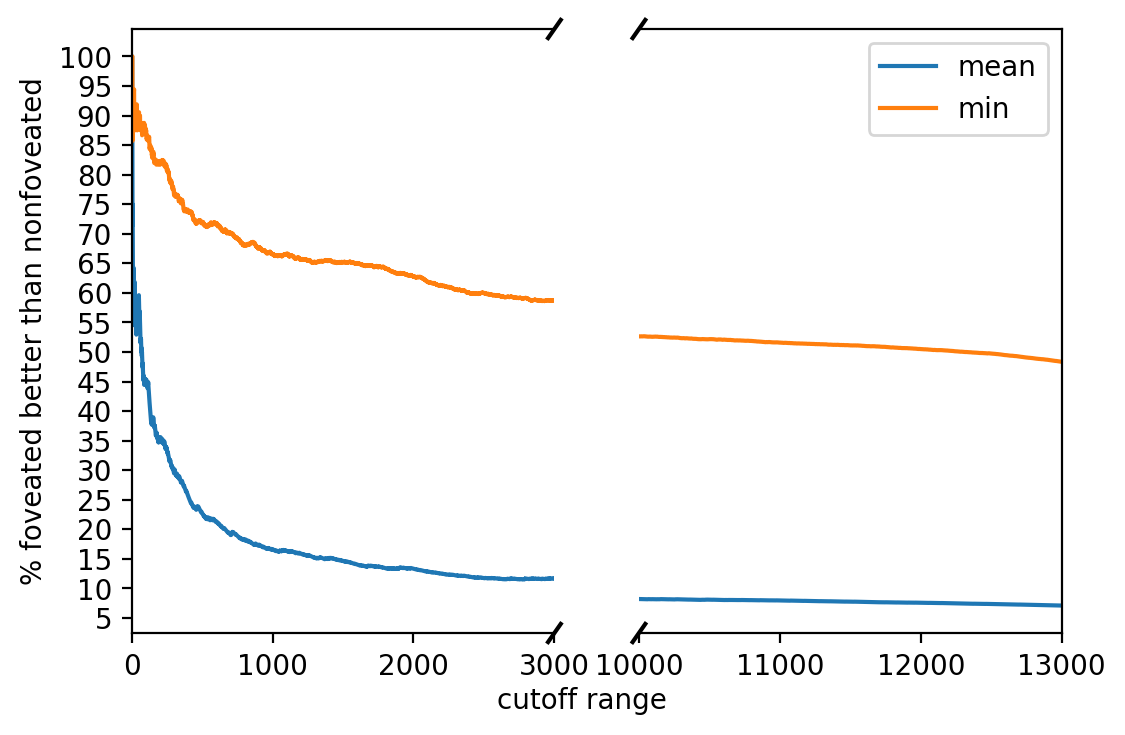

In [6]:
# https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html

fig, (ax, ax2) = plt.subplots(1, 2, dpi=200, facecolor='w', edgecolor='k', sharey=True)
fig.subplots_adjust(wspace=0.2)

# fig.font(size=12)
fig.text(0.5, 0.04, 'cutoff range', ha='center', va='center')

ax.plot(list(percentages_mean))
ax.plot(list(percentages_min))
ax.set(yticks=np.linspace(0,100,21), ylabel='% foveated better than nonfoveated')
ax.set_xlim(0, 3000)
ax.spines['right'].set_visible(False)
ax.yaxis.tick_left()

ax2.plot(list(percentages_mean))
ax2.plot(list(percentages_min))
# ax.yticks(np.linspace(0,100,41))
# ax.ylabel('percentage % better then nonfoveated')
# ax.xlabel('cutoff range')
ax2.legend(['mean', 'min'])
ax2.set_xlim(10000,len(result))
ax2.spines['left'].set_visible(False)
ax2.tick_params(left=False)  # don't put tick labels at the left

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # bottom-left diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # top right diagonal
ax2.plot((-d, +d), (-d, +d), **kwargs)  # bottom-right diagonal

fig.savefig("images/foveatedbetter_than_nonfoveated", bbox_inches='tight')
plt.show()

### WHAT IMAGES DO WELL/BAD 

In [7]:
def find(name, path):
    # https://stackoverflow.com/questions/1724693/find-a-file-in-python
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

In [8]:
cutoff = 50

betterFoveated = result[:cutoff].loc[result['nonfoveated'][:cutoff] > result['weak_mean'][:cutoff]]
im_names_better = list(betterFoveated['im_name'])
im_paths_better = [find(im_name + '.jpg', 'E:\\ILSVRC2017\\10classesfirst\\nofoveation') for im_name in im_names_better]
images_better = [cv2.imread(path) for path in im_paths_better]

worseFoveated = result[:cutoff].loc[result['nonfoveated'][:cutoff] < result['weak_mean'][:cutoff]]
im_names_worse =list(worseFoveated['im_name'])
im_paths_worse = [find(im_name+ '.jpg', 'E:\\ILSVRC2017\\10classesfirst\\nofoveation') for im_name in im_names_worse]
images_worse = [cv2.imread(path) for path in im_paths_worse]

print(len(images_better), len(images_worse))

29 21


In [9]:
result[:cutoff]

,im_name,nonfoveated,strong_center,strong_random,strong_min,strong_max,strong_mean,strong_std,weak_center,weak_random,weak_min,weak_max,weak_mean,weak_std
0,n01530575_3346,17.258446,5.132602,5.923322,3.761798,7.320805,5.730704,0.927431,8.693760,7.086637,6.730589,11.783422,8.910357,1.314212
1,n01531178_2254,12.412466,10.366248,10.366248,4.449660,15.027017,7.472886,2.322800,9.513043,11.312586,2.178160,14.791803,9.751821,3.678441
2,n01530575_10292,11.752517,7.265438,8.138165,4.030711,8.190363,6.250586,1.101559,11.626311,8.834952,6.989044,11.626311,8.919975,1.365228
3,n01532829_553,11.663983,6.486520,7.210282,6.486520,12.360573,9.141135,1.668115,6.354095,2.450802,2.450802,12.023178,5.664416,2.688922
4,n01532829_326,10.260677,9.615831,7.392079,6.596060,11.903097,8.571660,1.574298,9.306767,8.798142,6.321813,11.162496,9.042232,1.162068
5,n01534433_14325,10.121300,12.578758,8.965726,7.552979,12.578758,9.068700,1.336382,11.719564,10.096622,8.528928,13.573826,10.662624,1.311138
6,n01534433_14215,10.116632,15.991300,11.194634,8.356335,15.991300,10.332739,1.763498,13.731624,11.958741,10.618137,15.997592,12.522507,1.322975
7,n01532829_14733,9.932986,6.853777,8.552176,4.535553,8.552176,7.251291,1.010319,6.635473,6.207920,4.401717,9.862008,7.928345,1.259515
8,n01582220_8286,9.853064,14.061563,10.673339,8.952573,15.676153,11.480587,1.493043,9.716059,14.945496,6.579772,17.323391,14.168064,2.877050
9,n01558993_13680,9.705351,11.040298,9.029254,6.484106,13.176863,10.015456,1.797017,11.204837,11.106892,8.459014,12.829498,10.778438,1.337883


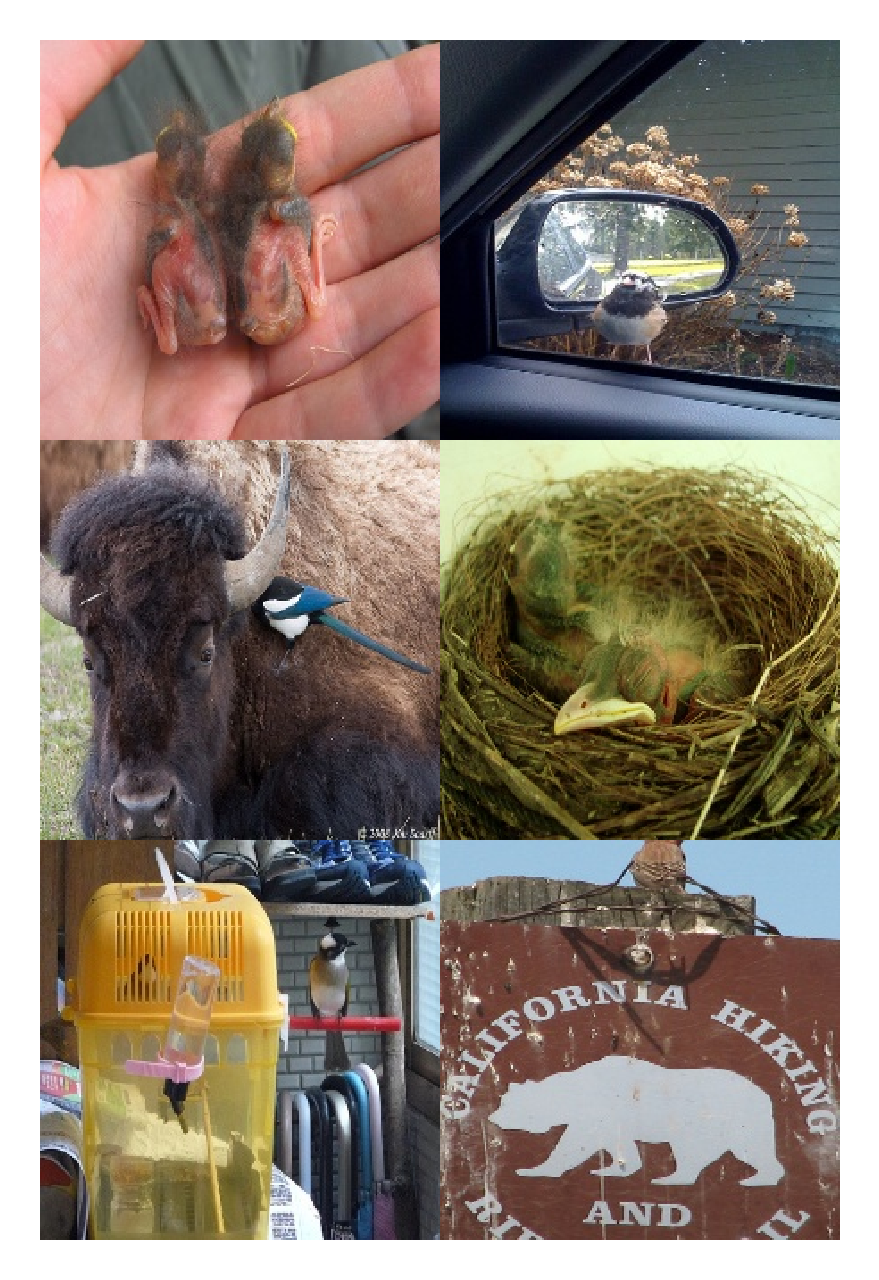

In [10]:
nrow = 3
ncol = 2

fig = plt.figure(figsize=(ncol+1, nrow+1), dpi=400) 

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

for i in range(nrow):
    for j in range(ncol):
        im = images_worse[i*ncol+j]
        RGB_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        ax= plt.subplot(gs[i,j])
        ax.imshow(RGB_img)
        ax.axis('off')
        
#plt.tight_layout() # do not use this!!
fig.savefig("images/worse", bbox_inches='tight')
plt.show()


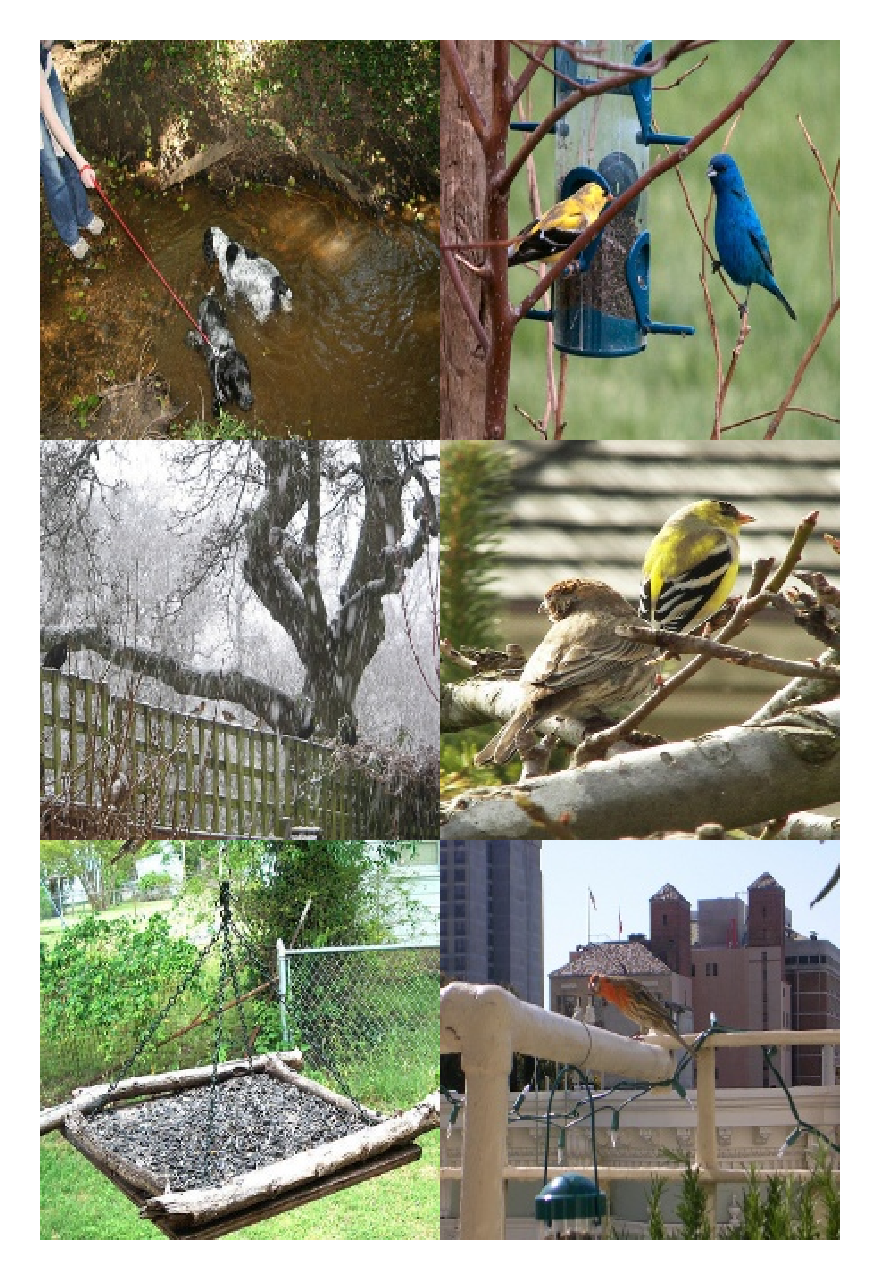

In [11]:
nrow = 3
ncol = 2

fig = plt.figure(figsize=(ncol+1, nrow+1), dpi=400) 

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

for i in range(nrow):
    for j in range(ncol):
        im = images_better[i*ncol+j]
        RGB_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        ax= plt.subplot(gs[i,j])
        ax.imshow(RGB_img)
        ax.axis('off')
        
#plt.tight_layout() # do not use this!!
fig.savefig("images/better", bbox_inches='tight')
plt.show()

In [12]:
worseFoveated[:6]



,im_name,nonfoveated,strong_center,strong_random,strong_min,strong_max,strong_mean,strong_std,weak_center,weak_random,weak_min,weak_max,weak_mean,weak_std
5,n01534433_14325,10.121300,12.578758,8.965726,7.552979,12.578758,9.068700,1.336382,11.719564,10.096622,8.528928,13.573826,10.662624,1.311138
6,n01534433_14215,10.116632,15.991300,11.194634,8.356335,15.991300,10.332739,1.763498,13.731624,11.958741,10.618137,15.997592,12.522507,1.322975
8,n01582220_8286,9.853064,14.061563,10.673339,8.952573,15.676153,11.480587,1.493043,9.716059,14.945496,6.579772,17.323391,14.168064,2.877050
9,n01558993_13680,9.705351,11.040298,9.029254,6.484106,13.176863,10.015456,1.797017,11.204837,11.106892,8.459014,12.829498,10.778438,1.337883
10,n01560419_5799,9.509518,13.612474,11.027729,9.935903,14.526443,12.111896,1.265424,10.498540,9.812243,6.326469,13.406948,10.974693,1.714606
14,n01532829_2675,9.273844,13.240524,12.307541,5.924277,14.816216,11.082865,2.440529,12.128946,11.975421,7.716980,14.829540,12.365145,2.034725


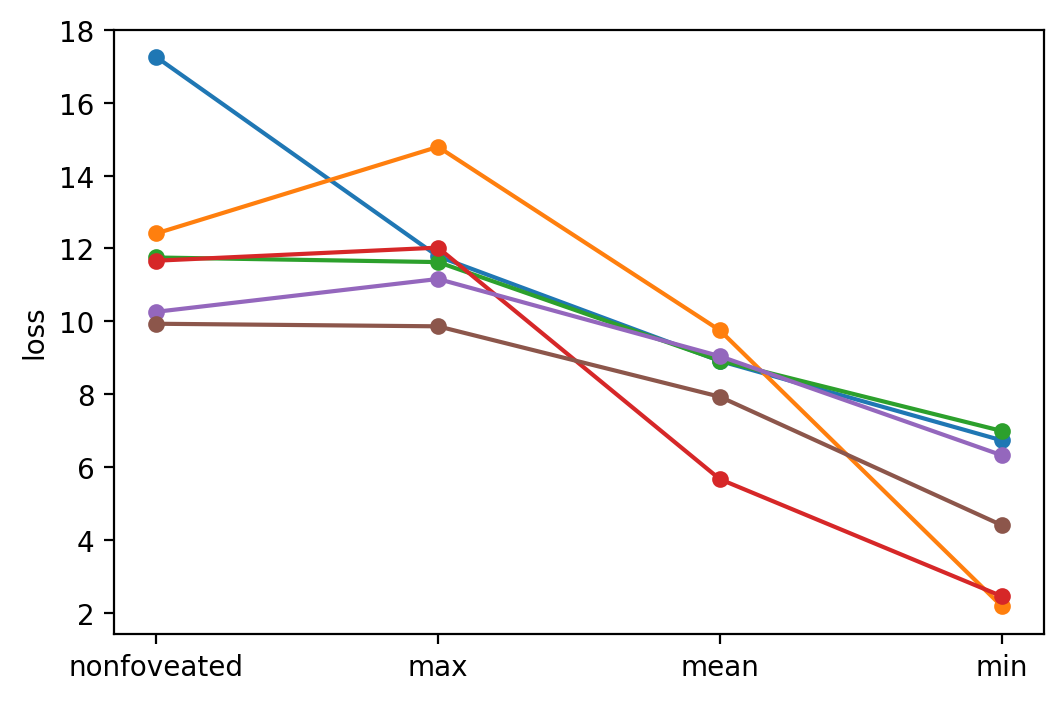

In [13]:
fig = plt.figure(dpi=200)

for _, r in betterFoveated[:6].iterrows():
#     print(r)
    plt.plot([r['nonfoveated'], r['weak_max'], r['weak_mean'], r['weak_min']], marker='.', markersize=10)
    
plt.ylabel('loss')
plt.xticks([0,1,2,3], ['nonfoveated', 'max', 'mean', 'min'])
fig.savefig("images/betterfoveationscores", bbox_inches='tight')

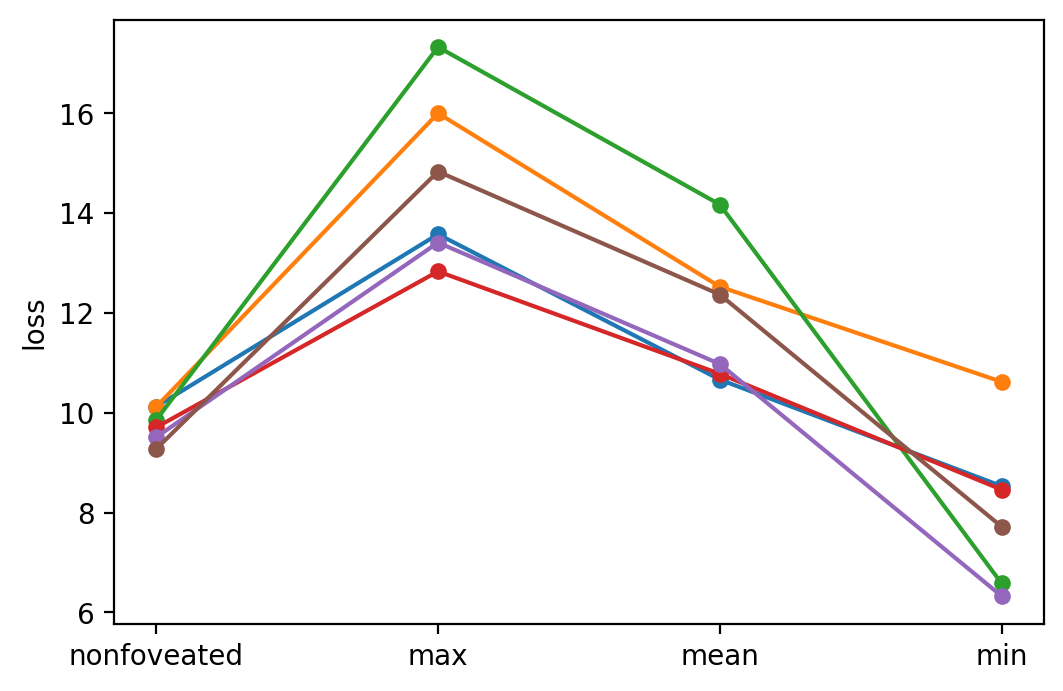

In [14]:
fig = plt.figure(dpi=200)
    
for _, r in worseFoveated[:6].iterrows():
#     print(r)
    plt.plot([r['nonfoveated'], r['weak_max'], r['weak_mean'], r['weak_min']], marker='.', markersize=10)
    
plt.ylabel('loss')
plt.xticks([0,1,2,3], ['nonfoveated', 'max', 'mean', 'min'])
fig.savefig("images/worsefoveationscores", bbox_inches='tight')

## Random, center, and min

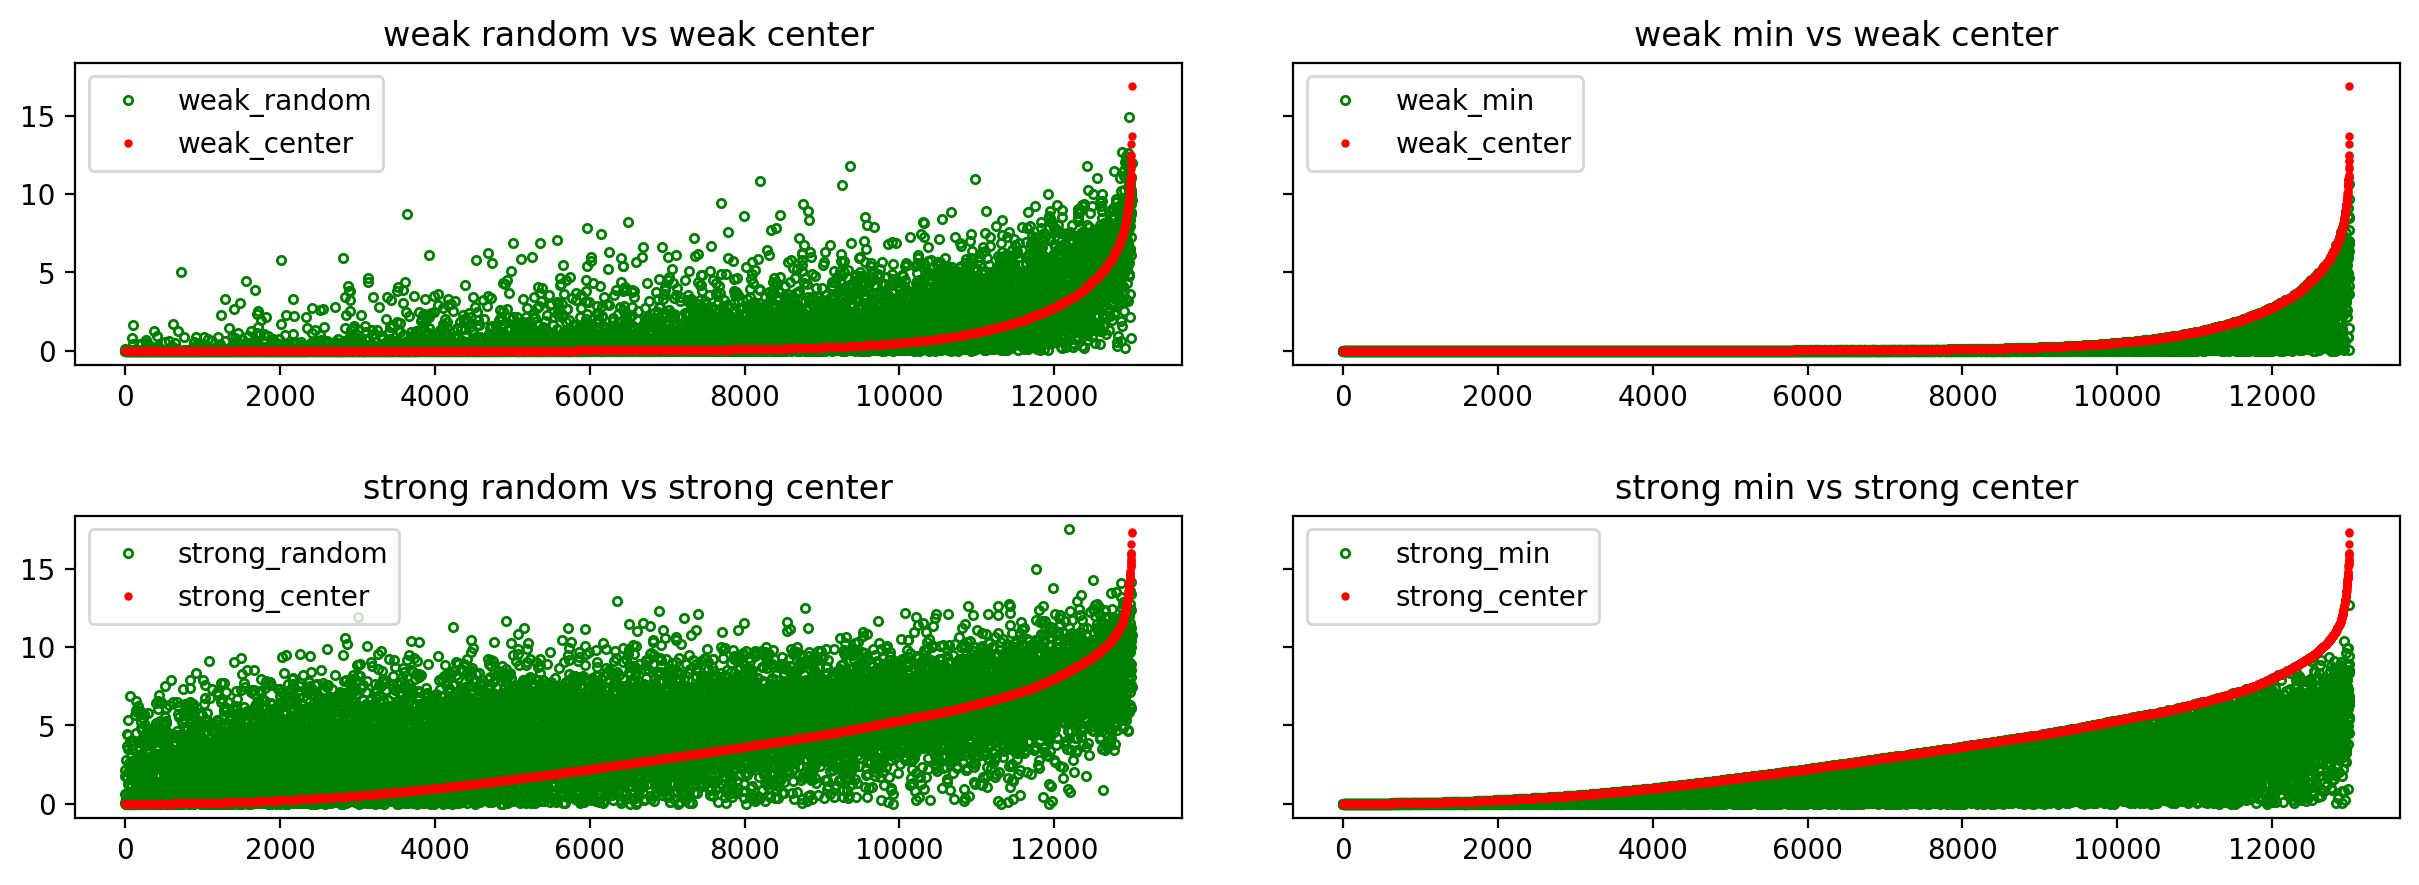

In [15]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,5), dpi=200)
fig.subplots_adjust(wspace=0.1, hspace=0.5)

"WEAK"
result = df.sort_values('weak_center')
result = result.reset_index(drop=True)

ax00 = ax[0,0]
ax00.plot(result['weak_random'], 'go', markersize=3, fillstyle='none')
ax00.plot(result['weak_center'], 'ro', markersize=2)
ax00.xaxis.set_ticks_position('bottom')
ax00.legend(['weak_random', 'weak_center'])
ax00.set_title('weak random vs weak center')

ax01 = ax[0,1]
ax01.plot(result['weak_min'], 'go', markersize=3, fillstyle='none')
ax01.plot(result['weak_center'], 'ro', markersize=2)
ax01.xaxis.set_ticks_position('bottom')
ax01.legend(['weak_min', 'weak_center'])
ax01.set_title('weak min vs weak center')

"STRONG"
result = df.sort_values('strong_center')
result = result.reset_index(drop=True)

ax10 = ax[1,0]
ax10.plot(result['strong_random'], 'go', markersize=3, fillstyle='none')
ax10.plot(result['strong_center'], 'ro', markersize=2)
ax10.xaxis.set_ticks_position('bottom')
ax10.legend(['strong_random', 'strong_center'])
ax10.set_title('strong random vs strong center')

ax11 = ax[1,1]
ax11.plot(result['strong_min'], 'go', markersize=3, fillstyle='none')
ax11.plot(result['strong_center'], 'ro', markersize=2)
ax11.xaxis.set_ticks_position('bottom')
ax11.legend(['strong_min', 'strong_center'])
ax11.set_title('strong min vs strong center')

plt.show()

## Foveation locations of min

In [16]:
weak_min_locations = [Q_Table_weak.columns[1:][np.argmin(i[1:])] for i in Q_Table_weak.values]
strong_min_locations = [Q_Table_strong.columns[1:][np.argmin(i[1:])] for i in Q_Table_strong.values]

In [17]:
print(strong_min_locations == '(5, 3)')

False


In [18]:
strong_unique, strong_counts = np.unique(strong_min_locations, return_counts=True)
print(strong_unique)
print(strong_counts)

['(0, 0)' '(0, 1)' '(0, 2)' '(0, 3)' '(0, 4)' '(1, 0)' '(1, 1)' '(1, 2)'
 '(1, 3)' '(1, 4)' '(2, 0)' '(2, 1)' '(2, 2)' '(2, 3)' '(2, 4)' '(3, 0)'
 '(3, 1)' '(3, 2)' '(3, 3)' '(3, 4)' '(4, 0)' '(4, 1)' '(4, 2)' '(4, 3)'
 '(4, 4)']
[ 106  216  176  115   57  335 1317 1095  471   56  439 2241 2084  652
   88  293 1149  985  451   68  105  174  182  105   40]


sanity checks that foveation locations are plotted correctly

 weak [('(0, 0)', 119), ('(0, 1)', 233), ('(0, 2)', 285), ('(0, 3)', 168), ('(0, 4)', 59), ('(1, 0)', 250), ('(1, 1)', 928), ('(1, 2)', 1188), ('(1, 3)', 618), ('(1, 4)', 124), ('(2, 0)', 394), ('(2, 1)', 1446), ('(2, 2)', 1963), ('(2, 3)', 1056), ('(2, 4)', 203), ('(3, 0)', 296), ('(3, 1)', 864), ('(3, 2)', 1199), ('(3, 3)', 637), ('(3, 4)', 143), ('(4, 0)', 94), ('(4, 1)', 194), ('(4, 2)', 292), ('(4, 3)', 167), ('(4, 4)', 80)]

 strong [('(0, 0)', 106), ('(0, 1)', 216), ('(0, 2)', 176), ('(0, 3)', 115), ('(0, 4)', 57), ('(1, 0)', 335), ('(1, 1)', 1317), ('(1, 2)', 1095), ('(1, 3)', 471), ('(1, 4)', 56), ('(2, 0)', 439), ('(2, 1)', 2241), ('(2, 2)', 2084), ('(2, 3)', 652), ('(2, 4)', 88), ('(3, 0)', 293), ('(3, 1)', 1149), ('(3, 2)', 985), ('(3, 3)', 451), ('(3, 4)', 68), ('(4, 0)', 105), ('(4, 1)', 174), ('(4, 2)', 182), ('(4, 3)', 105), ('(4, 4)', 40)]

 [['(0, 0)' '(1, 0)' '(2, 0)' '(3, 0)' '(4, 0)']
 ['(0, 1)' '(1, 1)'

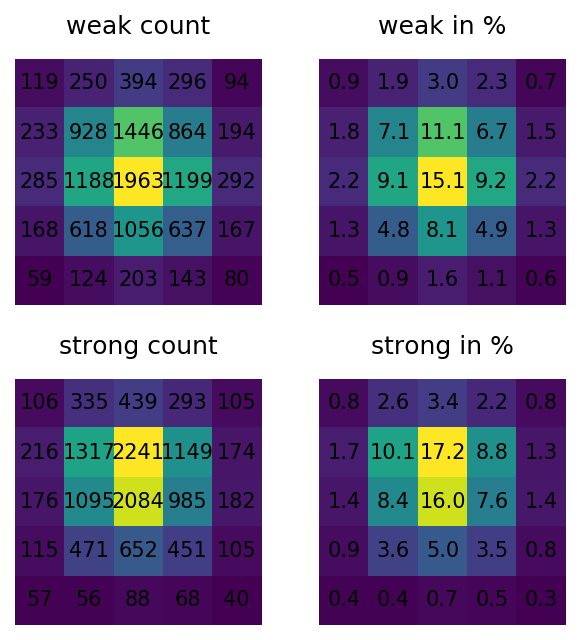

In [19]:
print("sanity checks that foveation locations are plotted correctly")
weak_unique, weak_counts = np.unique(weak_min_locations, return_counts=True)
print('\n weak', list(zip(weak_unique, weak_counts)))
weak_percentages = np.around((weak_counts / sum(weak_counts)) * 100, 2).reshape((5, 5)).transpose()
weak_unique = weak_unique.reshape((5, 5)).transpose()
weak_counts = weak_counts.reshape((5, 5)).transpose()

strong_unique, strong_counts = np.unique(strong_min_locations, return_counts=True)
print('\n strong', list(zip(strong_unique, strong_counts)))
strong_percentages = np.around((strong_counts / sum(strong_counts)) * 100, 2).reshape((5, 5)).transpose()
strong_unique = strong_unique.reshape((5, 5)).transpose()
strong_counts = strong_counts.reshape((5, 5)).transpose()

print('\n', weak_unique)

# Plot
fig, ax = plt.subplots(2, 2, figsize=(5,5), dpi=150, facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=0.1, hspace=0.3)

ax[0,0].matshow(weak_counts)
ax[0,0].axis('off')
ax[0,0].set_title('weak count')
for (i, j), z in np.ndenumerate(weak_counts):
    ax[0,0].text(j, i, '{}'.format(z), ha='center', va='center')
    
ax[0,1].matshow(weak_percentages)
ax[0,1].axis('off')
ax[0,1].set_title('weak in %')
for (i, j), z in np.ndenumerate(weak_percentages):
    ax[0,1].text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    
ax[1,0].matshow(strong_counts)
ax[1,0].axis('off')
ax[1,0].set_title('strong count')
for (i, j), z in np.ndenumerate(strong_counts):
    ax[1,0].text(j, i, '{}'.format(z), ha='center', va='center')
    
ax[1,1].matshow(strong_percentages)
ax[1,1].axis('off')
ax[1,1].set_title('strong in %')
for (i, j), z in np.ndenumerate(strong_percentages):
    ax[1,1].text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

## What are good/bad images to foveate?

In [20]:
total = 6500

better_locations = []
equal_locations = []
worse_locations = []

better_class = []
equal_class = []
worse_class = []

better_imagenames = []
equal_imagenames = []
worse_imagenames = []

for (i, row1), (i, row2) in zip(Q_Table_weak.iterrows(), temp.iterrows()):
       
    lowest_value = row1[1:].min()
    lowest_location = pd.to_numeric(row1[1:]).idxmin()
    image_name = row1[0]
    image_class = image_name.split('_')[0]
    
    # better performance
    if lowest_value < row2['nonfoveated']:
        better_locations.append(lowest_location)
        better_class.append(image_class)
        better_imagenames.append(image_name)
    # equal performance
    elif lowest_value == row2['nonfoveated']:
        equal_locations.append(lowest_location)
        equal_class.append(image_class)
        equal_imagenames.append(image_name)
    # worse performance
    elif lowest_value > row2['nonfoveated']:
        worse_locations.append(lowest_location)
        worse_class.append(image_class)
        worse_imagenames.append(image_name)
    else:
        print("the universe exploded")
        break
        
print('Better performance of foveated images then non-foveated on the 6500 test images: %d %%' % (
100 * len(better_locations) / total))
print('Worse performance of foveated images then non-foveated on the 6500 test images: %d %%' % (
100 * len(worse_locations) / total))

NameError: name 'temp' is not defined

### Locations

In [ ]:
better_unique, better_counts = np.unique(better_locations, return_counts=True)
better_percentages = np.around((better_counts / sum(better_counts)) * 100, 2).reshape((5, 5))

# equal_unique, equal_counts = np.unique(equal_locations, return_counts=True)
# equal_percentages = np.around((equal_counts / sum(equal_counts)) * 100, 2).reshape((5, 5))

worse_unique, worse_counts = np.unique(worse_locations, return_counts=True)
worse_percentages = np.around((worse_counts / sum(worse_counts)) * 100, 2).reshape((5, 5))

# Plot
fig, ax = plt.subplots(3, 2, figsize=(10,10), dpi=200, facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=0.1, hspace=0.3)

ax[0,0].matshow(better_counts.reshape((5, 5)))
ax[0,0].axis('off')
ax[0,0].set_title('better count')
for (i, j), z in np.ndenumerate(better_counts.reshape((5, 5))):
    ax[0,0].text(j, i, '{}'.format(z), ha='center', va='center')
    
ax[0,1].matshow(better_percentages)
ax[0,1].axis('off')
ax[0,1].set_title('better in %')
for (i, j), z in np.ndenumerate(better_percentages):
    ax[0,1].text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    
# ax[1,0].matshow(equal_counts.reshape((5, 5)))
# ax[1,0].axis('off')
# ax[1,0].set_title('equal count')
# for (i, j), z in np.ndenumerate(equal_counts.reshape((5, 5))):
#     ax[1,0].text(j, i, '{}'.format(z), ha='center', va='center')
    
# ax[1,1].matshow(equal_percentages)
# ax[1,1].axis('off')
# ax[1,1].set_title('equal in %')
# for (i, j), z in np.ndenumerate(equal_percentages):
#     ax[1,1].text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    
ax[2,0].matshow(worse_counts.reshape((5, 5)))
ax[2,0].axis('off')
ax[2,0].set_title('worse count')
for (i, j), z in np.ndenumerate(worse_counts.reshape((5, 5))):
    ax[2,0].text(j, i, '{}'.format(z), ha='center', va='center')
    
ax[2,1].matshow(worse_percentages)
ax[2,1].axis('off')
ax[2,1].set_title('worse in %')
for (i, j), z in np.ndenumerate(worse_percentages):
    ax[2,1].text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

### Classes

In [ ]:
better_unique, better_counts = np.unique(better_class, return_counts=True)
better_percentages = np.around((better_counts / sum(better_counts)) * 100, 2)

worse_unique, worse_counts = np.unique(worse_class, return_counts=True)
worse_percentages = np.around((worse_counts / sum(worse_counts)) * 100, 2)

fig=plt.figure(dpi=200, facecolor='w', edgecolor='k')
plt.hist([better_class, worse_class])
plt.title('classes')
plt.legend(['better performance', 'worse performance'])
plt.xlabel('class')
plt.ylabel('frequency')
plt.show()

### Images

In [ ]:
# print(better_imagenames)
# print(worse_imagenames)


